### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
import json

from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline

### Measure functions: Timing

In [2]:
def timing(function):
    def wrap(*args):
        startTime = time.time()
        ret = function(*args)
        endTime = time.time()
        print ('%s function took %0.3f ms' % (function.__name__, (endTime-startTime)*1000.0))
        return ret
    return wrap

### Machine Learning Model with Logistic Regression

In [3]:
class machineLearning:
    
    @timing
    def fit(self, df):        
        x1, y1 = correlation().calculateAxes(df)
        
        x1 = np.asarray(x1)
        x1 = x1.reshape(-1, 1)

        y1 = np.asarray(y1)
        y1 = y1.reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=1)
        
        log = linear_model.LogisticRegression()        
        
        log.fit(x_train, y_train.ravel())
        
        y_pred = log.predict(x_test)
        
        print("\nScore Logistic Regression: " + str(log.score(x_test, y_test)) + '\n')
        
        return log
    
    @timing
    def predict(self, df, X):        
        model = self.fit(df)
        predict = model.predict(X)
        return json.dumps({"predict":int(predict)})

### Correlation

In [4]:
class correlation:
    # Calculate the axes values (x = length of word / y = count of related lemmas)
    @timing
    def calculateAxes(self, df):
        x = []
        y = []
        
        for row in df.values:
            linha = [''.join(row[:1]), [x for x in row[1:] if x is not None and x != '']]
            x.append(len(linha[0]))
            y.append(len(linha[1]))

        return x, y
    
    @timing
    def calculateCorrelation(self, df):        
        x, y = self.calculateAxes(df)

        output = pd.DataFrame()
        output['x'] = x
        output['y'] = y

        corr = output['x'].corr(output['y'])
        return json.dumps({"correlation": corr})

### API

In [5]:
class api:
    # FileName = name of input file
    # SeparatorWord = separator for word
    # SeparatorLemmas = separator for lemmas
    def __init__(self):
        self.fileName = None
        self.separatorWord = None
        self.separatorLemmas = None

    # Parse input file to Pandas DataFrame
    @timing
    def parseFile(self):
        file = pd.DataFrame(line.strip().split(self.separatorWord) for line in open(self.fileName, 'r'))
        file.columns = ['word', 'lemmas']

        parsed = pd.DataFrame(file.lemmas.str.split(self.separatorLemmas).tolist(), file['word']).add_prefix('lemma_')
        parsed.index.rename('word', inplace=True)
        parsed.reset_index(inplace=True)

        parsed['word'] = parsed['word'].str.strip()

        return parsed
    
    @timing
    def correlation(self):
        df = self.parseFile()
        return correlation().calculateCorrelation(df)
    
    @timing
    def predictMachineLearning(self, X):
        df = self.parseFile()
        predict = machineLearning().predict(df, X)
        return predict

In [6]:
test = api()

In [7]:
test.fileName = 'AntBNC_lemmas_ver_001.txt'
test.separatorWord = '->'
test.separatorLemmas = '\t'

In [8]:
result = test.correlation()
print('\nCorrelation between the length of a word and the number of lemmas it has: ')
print(result)
del result # free memory

parseFile function took 135.008 ms
calculateAxes function took 199.011 ms
calculateCorrelation function took 235.013 ms
correlation function took 376.022 ms

Correlation between the length of a word and the number of lemmas it has: 
{"correlation": -0.2878409636953036}


In [9]:
predict = test.predictMachineLearning(6)
print('\nNew predict for word with lenght 6, number of lemmas is: ')
print(predict)
del predict # free memory

parseFile function took 172.010 ms
calculateAxes function took 199.011 ms

Score Logistic Regression: 0.788970683198

fit function took 392.023 ms
predict function took 393.023 ms
predictMachineLearning function took 570.032 ms

New predict for word with lenght 6, number of lemmas is: 
{"predict": 2}


### Exploratory analysis

In [10]:
df = test.parseFile()
x, y = correlation().calculateAxes(df)
del df # free memory

parseFile function took 215.012 ms
calculateAxes function took 193.011 ms


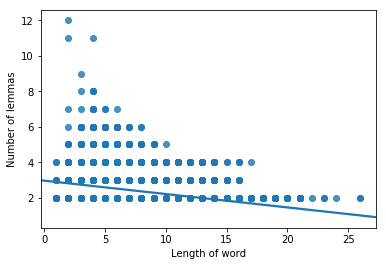

In [11]:
reg = sb.regplot(x=np.array(x), y=np.array(y))
reg.set(xlabel='Length of word', ylabel='Number of lemmas')
plt.show()
del reg

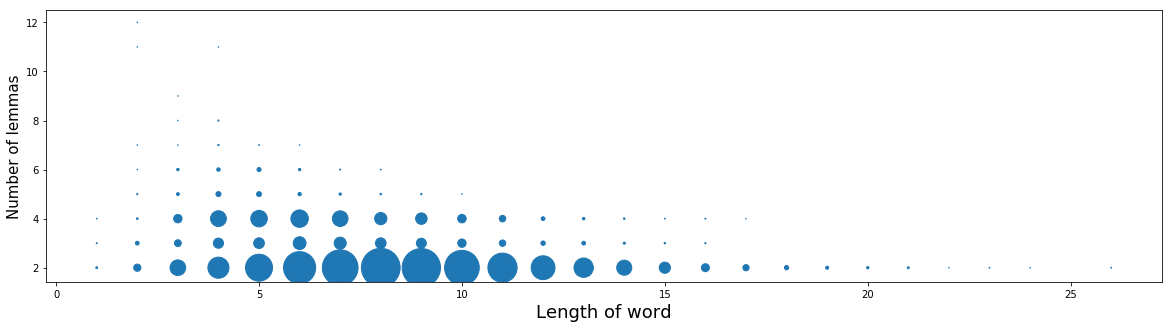

In [12]:
bubble = pd.DataFrame()
bubble['x'] = x
bubble['y'] = y
bubble['c'] = 1
bubble = bubble.groupby(['x', 'y'])['c'].sum().reset_index()

fig = plt.figure(figsize=(20,5))
plt.scatter(bubble['x'], bubble['y'], s=bubble['c']/3)
plt.xlabel("Length of word", fontsize=18)
plt.ylabel("Number of lemmas", fontsize=15)

del bubble, fig # free memory

In [13]:
del test # free memory